# Importing libraries

In [116]:
import cudf
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from packaging import version
if version.parse(cp.__version__) >= version.parse("10.0.0"):
    cupy_from_dlpack = cp.from_dlpack
else:
    cupy_from_dlpack = cp.fromDlpack
plt.figure(figsize=(5,5))

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

# Reading Files

reading all the training files and storing the objects in list

In [2]:
df = [cudf.read_csv('train_{}.csv'.format(i)) for i in range(10)]

In [3]:
df[0].describe()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,...,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
count,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.130390e+06,...,2.130318e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06
mean,3.678573e+02,3.678601e+05,-6.615076e+01,-1.711840e-01,-8.702000e-03,1.566230e+01,-3.763000e-03,2.237900e-02,1.148250e-01,-8.151900e-02,...,4.577625e+01,-2.727069e+00,-2.754303e+00,-3.226214e+00,-3.220364e+00,-2.751841e+00,-2.718325e+00,1.604489e+00,5.831100e-02,5.575300e-02
std,2.125500e+02,2.125501e+05,6.682579e+01,4.909460e+01,6.008009e+01,1.044591e+01,2.316391e+01,2.806578e+01,1.228911e+01,4.550489e+01,...,3.410338e+01,3.301398e+00,3.306345e+00,3.364020e+00,3.363124e+00,3.306341e+00,3.300695e+00,2.080762e+00,2.343300e-01,2.294440e-01
min,1.000000e+00,1.002000e+03,-7.205285e+02,-8.079200e+01,-1.043092e+02,1.296000e+00,-9.920059e+01,-8.797200e+01,-6.299300e+01,-8.189000e+01,...,0.000000e+00,-9.984000e+00,-9.984000e+00,-9.970000e+00,-9.984000e+00,-9.970000e+00,-9.970000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,1.830000e+02,1.830040e+05,-9.148513e+01,-4.498640e+01,-5.354000e+01,6.395000e+00,-1.558660e+01,-2.184260e+01,-7.648400e+00,-3.730970e+01,...,1.294000e+01,-5.477000e+00,-5.527000e+00,-6.200000e+00,-6.195000e+00,-5.523000e+00,-5.465000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.650000e+02,3.650040e+05,-4.588233e+01,-0.000000e+00,0.000000e+00,1.412580e+01,-0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,...,4.275000e+01,-6.904000e-01,-7.900000e-01,-2.193000e+00,-2.186000e+00,-7.803000e-01,-6.540000e-01,1.000000e+00,0.000000e+00,0.000000e+00
75%,5.530000e+02,5.530020e+05,-1.925391e+01,4.450460e+01,5.377380e+01,2.366960e+01,1.563160e+01,2.181040e+01,7.640200e+00,3.711940e+01,...,7.694000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
max,7.370000e+02,7.370050e+05,-1.714600e-02,8.069160e+01,1.043092e+02,3.943720e+01,9.838720e+01,1.011442e+02,6.794280e+01,8.190180e+01,...,1.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00


check if all the columns have minimum value greater than -127 and maximum value less than 128, then we can convert their dtypes to int8. Such that it will take less memory and would be faster to compute

In [4]:
min_max_df = cudf.DataFrame(columns = df[0].columns)
for j in range(3,58):
    mini = 128
    maxi = -127
    for i in range(10):
        mini = min(mini, df[i].iloc[:, j].min())
        maxi = max(maxi, df[i].iloc[:, j].max())
        min_max_df[df[i].iloc[0:0, j].name] = cudf.Series([mini, maxi])
min_max_df = min_max_df.drop(['game_num', 'event_id', 'event_time', 'team_scoring_next', 'team_A_scoring_within_10sec','team_B_scoring_within_10sec'], axis=1)

In [5]:
min_a = cudf.Series([min_max_df[column][0]>-127 for column in min_max_df.columns])
max_a = cudf.Series([min_max_df[column][0]<128 for column in min_max_df.columns])
print("all values are in range of int8: {}".format(min_a.all() and max_a.all()))

all values are in range of int8: True


We should re-cast the dtypes for these columns to `int8`

In [6]:
def mem_usage(df):
    return df.memory_usage().sum()/1024/1024

In [7]:
for i in range(10):
    print ("Train_{}.csv memory usage: {:.2f} MB".format(i, mem_usage(df[i])))

Train_0.csv memory usage: 1004.69 MB
Train_1.csv memory usage: 1013.76 MB
Train_2.csv memory usage: 993.54 MB
Train_3.csv memory usage: 988.48 MB
Train_4.csv memory usage: 989.97 MB
Train_5.csv memory usage: 978.71 MB
Train_6.csv memory usage: 964.80 MB
Train_7.csv memory usage: 986.14 MB
Train_8.csv memory usage: 1005.86 MB
Train_9.csv memory usage: 982.93 MB


In [8]:
df[0].info(verbose=True)

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 2149381 entries, 0 to 2149380
Data columns (total 61 columns):
 #   Column                       Dtype
---  ------                       -----
 0   game_num                     int64
 1   event_id                     int64
 2   event_time                   float64
 3   ball_pos_x                   float64
 4   ball_pos_y                   float64
 5   ball_pos_z                   float64
 6   ball_vel_x                   float64
 7   ball_vel_y                   float64
 8   ball_vel_z                   float64
 9   p0_pos_x                     float64
 10  p0_pos_y                     float64
 11  p0_pos_z                     float64
 12  p0_vel_x                     float64
 13  p0_vel_y                     float64
 14  p0_vel_z                     float64
 15  p0_boost                     float64
 16  p1_pos_x                     float64
 17  p1_pos_y                     float64
 18  p1_pos_z                     float64
 19  p1_vel

In [9]:
def ctype(df):
    df.event_time = df.event_time.astype('float32')
    df.game_num = df.game_num.astype('uint16')
    df.event_id = df.event_id.astype('uint32')
    first = df.iloc[:, 0:3]
    mid = df.iloc[:, 3:58].astype('int8')
    first = cudf.concat([first, mid], axis=1)
    second = df.iloc[:, 58:59]
    first = cudf.concat([first, second], axis=1)
    third = df.iloc[:, 59:].astype('int8')
    first = cudf.concat([first, third], axis=1)
    return first

we need absolute of time, sign doesn't matter

changing required dtypes of columns

In [10]:
for i in range(10):df[i]=ctype(df[i])

In [11]:
for i in range(10):
    print ("Train_{}.csv memory usage: {:.2f} MB".format(i, mem_usage(df[i])))

Train_0.csv memory usage: 158.12 MB
Train_1.csv memory usage: 159.55 MB
Train_2.csv memory usage: 156.38 MB
Train_3.csv memory usage: 155.61 MB
Train_4.csv memory usage: 155.82 MB
Train_5.csv memory usage: 154.06 MB
Train_6.csv memory usage: 151.88 MB
Train_7.csv memory usage: 155.22 MB
Train_8.csv memory usage: 158.32 MB
Train_9.csv memory usage: 154.70 MB


lets' concatenate the 10 files first, and then try to reduce the memory further

In [12]:
df = cudf.concat(df)

split the `team_scoring_next` column in two parts

In [13]:
def oneHot(df):
    a_scored = cudf.Series(df.team_scoring_next.where(df.team_scoring_next=='A').fillna(0), name='a_scored')
    b_scored = cudf.Series(df.team_scoring_next.where(df.team_scoring_next=='B').fillna(0), name='b_scored')
    a_scored[a_scored=='A']='1'
    b_scored[b_scored=='B']='1'
    a_scored = a_scored.astype('int8')
    b_scored = b_scored.astype('int8')
    return a_scored, b_scored

drop `team_scoring_next` column and add oneHot(df) columns

In [14]:
df.team_scoring_next

0             B
1             B
2             B
3             B
4             B
           ... 
2102808    <NA>
2102809    <NA>
2102810    <NA>
2102811    <NA>
2102812    <NA>
Name: team_scoring_next, Length: 21198036, dtype: object

In [15]:
a_scored, b_scored = oneHot(df)
df = df.drop(labels=['team_scoring_next'], axis=1)
df.insert(58, value=a_scored, name='team_A_scored')
df.insert(59, value=a_scored, name='team_B_scored')

In [16]:
df.info(verbose=True)

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 21198036 entries, 0 to 2102812
Data columns (total 62 columns):
 #   Column                       Dtype
---  ------                       -----
 0   game_num                     uint16
 1   event_id                     uint32
 2   event_time                   float32
 3   ball_pos_x                   int8
 4   ball_pos_y                   int8
 5   ball_pos_z                   int8
 6   ball_vel_x                   int8
 7   ball_vel_y                   int8
 8   ball_vel_z                   int8
 9   p0_pos_x                     int8
 10  p0_pos_y                     int8
 11  p0_pos_z                     int8
 12  p0_vel_x                     int8
 13  p0_vel_y                     int8
 14  p0_vel_z                     int8
 15  p0_boost                     int8
 16  p1_pos_x                     int8
 17  p1_pos_y                     int8
 18  p1_pos_z                     int8
 19  p1_vel_x                     int8
 20  p1_vel_y    

In [17]:
print("Total memory footprint of all Train files is: {:.2f} MB".format(mem_usage(df)))

Total memory footprint of all Train files is: 1662.77 MB


So we have reduced the memory footprint of whole training dataset from around `9GB` to `1.6GB`, this is 83% reduction in memory

In [18]:
df.event_time[df.event_time>=0]

Series([], Name: event_time, dtype: float32)

now `event_time` is having all negative values, so we can apply absolute over the column

In [19]:
df.event_time = df.event_time.abs()

In [ ]:
df['p0_pos_x'][df[]]

# Checking null vallues

In [39]:
null_columns = []
def checkna(df, l):
    for col in df.columns:
        a = df[col].isna().value_counts()
        if a.size>1:
            print(col, "=>",df[col].isna().value_counts()[1])
            l.append(col)
    return l
null_columns = checkna(df, null_columns)

p0_pos_x => 188648
p0_pos_y => 188648
p0_pos_z => 188648
p0_vel_x => 188648
p0_vel_y => 188648
p0_vel_z => 188648
p0_boost => 188648
p1_pos_x => 189969
p1_pos_y => 189969
p1_pos_z => 189969
p1_vel_x => 189969
p1_vel_y => 189969
p1_vel_z => 189969
p1_boost => 189969
p2_pos_x => 189350
p2_pos_y => 189350
p2_pos_z => 189350
p2_vel_x => 189350
p2_vel_y => 189350
p2_vel_z => 189350
p2_boost => 189350
p3_pos_x => 194644
p3_pos_y => 194644
p3_pos_z => 194644
p3_vel_x => 194644
p3_vel_y => 194644
p3_vel_z => 194644
p3_boost => 194644
p4_pos_x => 195442
p4_pos_y => 195442
p4_pos_z => 195442
p4_vel_x => 195442
p4_vel_y => 195442
p4_vel_z => 195442
p4_boost => 195442
p5_pos_x => 193658
p5_pos_y => 193658
p5_pos_z => 193658
p5_vel_x => 193658
p5_vel_y => 193658
p5_vel_z => 193658
p5_boost => 193658


it is given that players will have `NaN` values iff following player been demolished by another player, and so then that player will respawn in few seconds. 
So, by that time `position`, `velocity` and `boost` of player didn't change at all. For that period of time we can take `mean` of the values when player got demolished and when it reswamped for all the three features of all the players.

In [44]:
for c in null_columns:
    df[c] = df[c].fillna(df[c].mean().astype('int8'))

In [45]:
checkna(df,[])

[]

we have successfully filled up `NAN`

# Defining Functions

In [59]:
def histogram(df, v):
    if v: 
        print("min: {}".format(df.min()))
        print("max: {}".format(df.max()))
        print(df.name)
    arr_cupy = cupy_from_dlpack(df.to_dlpack())
    arr = cp.histogram(arr_cupy, bins = abs(-int(df.min())+int(df.max())))
    plt.figure(figsize=(3,3))
    plt.bar(range(int(df.min()), int(df.max())), height = arr[0].tolist())
    plt.show()

In [61]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 21198036 entries, 0 to 2102812
Data columns (total 62 columns):
 #   Column                       Dtype
---  ------                       -----
 0   game_num                     uint16
 1   event_id                     uint32
 2   event_time                   float32
 3   ball_pos_x                   int8
 4   ball_pos_y                   int8
 5   ball_pos_z                   int8
 6   ball_vel_x                   int8
 7   ball_vel_y                   int8
 8   ball_vel_z                   int8
 9   p0_pos_x                     int8
 10  p0_pos_y                     int8
 11  p0_pos_z                     int8
 12  p0_vel_x                     int8
 13  p0_vel_y                     int8
 14  p0_vel_z                     int8
 15  p0_boost                     int8
 16  p1_pos_x                     int8
 17  p1_pos_y                     int8
 18  p1_pos_z                     int8
 19  p1_vel_x                     int8
 20  p1_vel_y    

# EDA

## Heatmap

In [69]:
heat_df = df[['p0_pos_x', 'p1_pos_x', 'p2_pos_x', 'p3_pos_x', 'p4_pos_x', 'p5_pos_x', 'ball_pos_x', 'ball_pos_y', 'ball_pos_z']].corr()

In [174]:
def heatmap(df,l):
    plt.figure(figsize=(len(l),len(l)/2))
    corr = df[l].corr() 
    corr_np = np.around(corr.to_numpy(), decimals=4)
    ax = sns.heatmap(corr_np,annot=True, cmap=sns.cubehelix_palette(as_cmap=True),linewidth=0.5)
    ax.set_xticks(np.arange(len(l)), labels=l)
    ax.set_yticks(np.arange(len(l)), labels=l)
    ax.xaxis.tick_top()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor")
    plt.show()

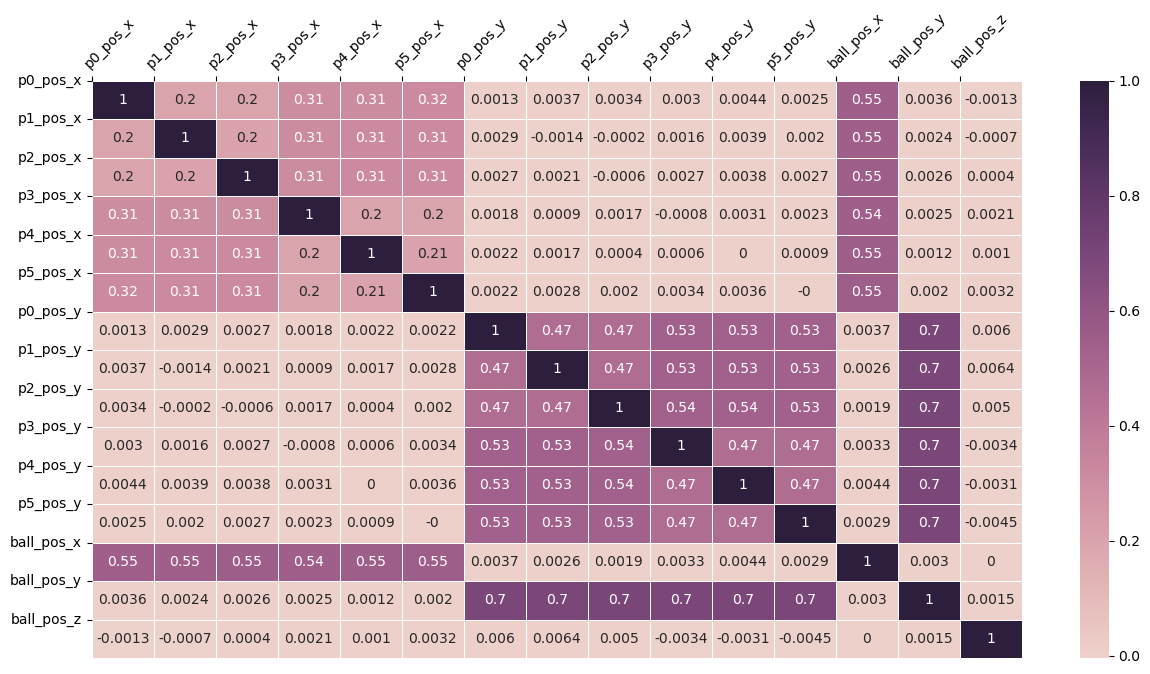

In [170]:
heatmap(df,['p0_pos_x', 'p1_pos_x', 'p2_pos_x', 'p3_pos_x', 'p4_pos_x', 'p5_pos_x', 'p0_pos_y', 'p1_pos_y', 'p2_pos_y', 'p3_pos_y', 'p4_pos_y', 'p5_pos_y','ball_pos_x', 'ball_pos_y', 'ball_pos_z'])

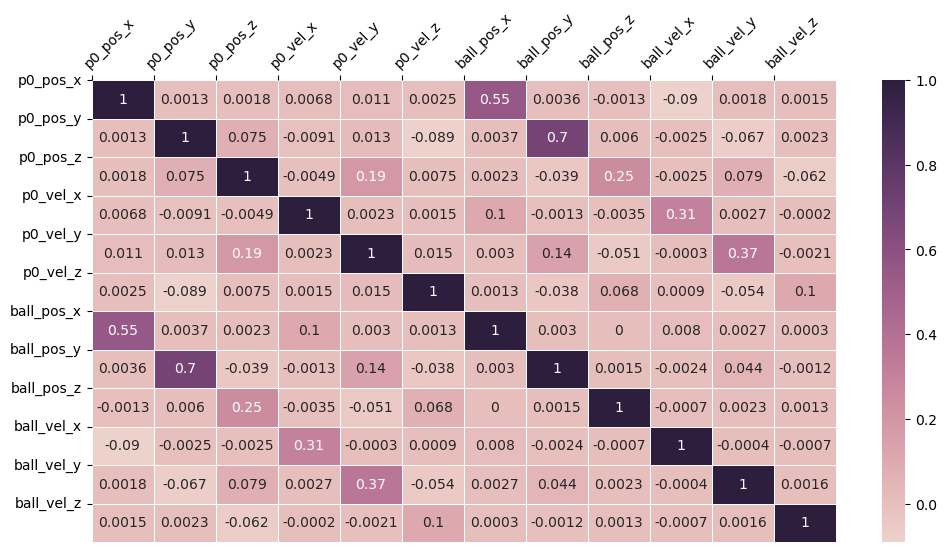

In [173]:
heatmap(df, ['p0_pos_x', 'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y','p0_vel_z', 'ball_pos_x','ball_pos_y','ball_pos_z', 'ball_vel_x','ball_vel_y','ball_vel_z'])

from above heatmaps we can say that x component has more correlation with x component which could also be like, x component of one player affect x component of another(here ball). So x can be any of the component x, y, z

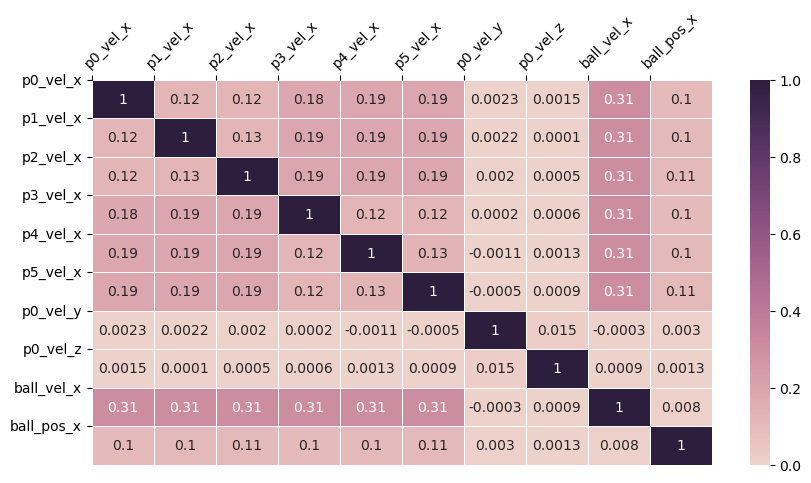

In [185]:
heatmap(df, ['p0_vel_x', 'p1_vel_x', 'p2_vel_x', 'p3_vel_x', 'p4_vel_x', 'p5_vel_x', 'p0_vel_y','p0_vel_z','ball_vel_x', 'ball_pos_x'])

velocities of all the players in x direction affect the velocity of ball in x more than y and z of any random player

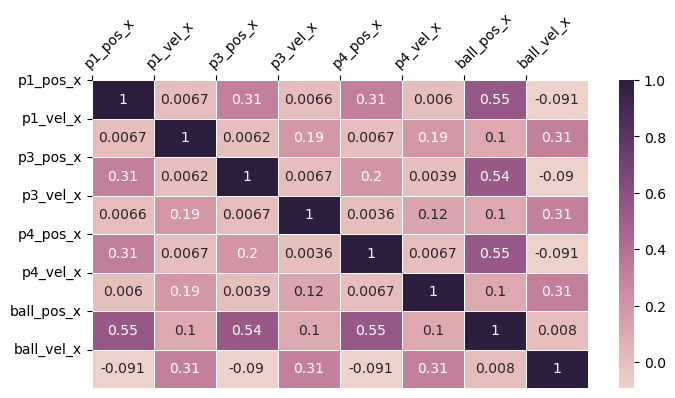

In [189]:
heatmap(df, ['p1_pos_x', 'p1_vel_x', 'p3_pos_x', 'p3_vel_x', 'p4_pos_x', 'p4_vel_x', 'ball_pos_x', 'ball_vel_x'])

above two heatmaps shows that velocity of any entity is correlated with velocity of another entity and position of any entity is correlated with position of another entity. But velocity of one doesn't have much effect on position of another. Thw following was for players

But velocity of player will be linearly correlated with position and velocity of the ball
and position of player will be linearly correlated with position of ball, non linearly with velocity of ball

## Findings - heatmap

1. $i^{th}$ component of position or velocity of a player is more correlated with $i^{th}$ component of position or velocity respectively of another's player
2. players' velocity affect ball's position and velocity 
3. player's current position affect position of ball more than velocity of ball

# Histograms

## Event Time

Time in seconds before the event ended, either by a goal being scored or simply when we decided to truncate the timeseries if a goal was not scored.

In [ ]:
(df.event_time[df.event_time<300].size/df.event_time.size)*100

In [ ]:
new_event_time = df.event_time[df.event_time<300]

In [ ]:
histogram(new_event_time, True)

In [ ]:
df.event_time[df.event_time].size

In [ ]:
new_event_time.min()

In [ ]:
new_event_time.max()

## ball position

### Pos X

In [ ]:
histogram(df.ball_pos_x, True)

In [ ]:
a = df.team_scoring_next[df['team_scoring_next']!='A']
a[a!='B']

In [ ]:
df[0].team_scoring_next.value_counts(dropna=False)

min: 1
max: 7365
game_num


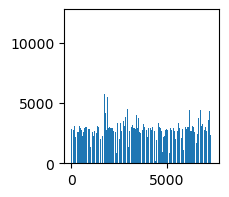

min: 0.016755200922489166
max: 919.809814453125
event_time


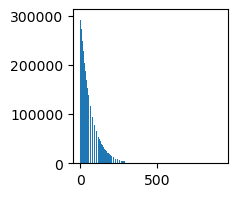

min: -80
max: 80
ball_pos_x


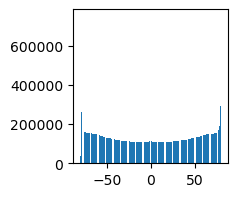

min: -104
max: 104
ball_pos_y


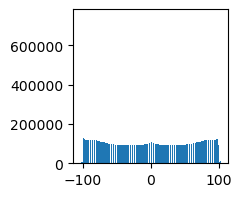

min: 1
max: 39
ball_pos_z


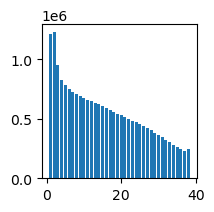

min: -108
max: 115
ball_vel_x


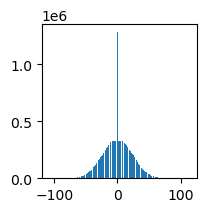

min: -111
max: 105
ball_vel_y


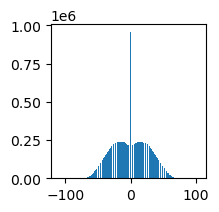

min: -65
max: 90
ball_vel_z


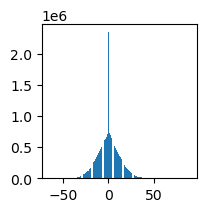

min: -81
max: 82
p0_pos_x


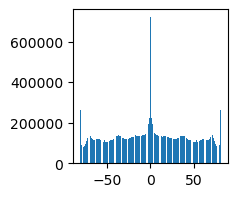

min: -119
max: 119
p0_pos_y


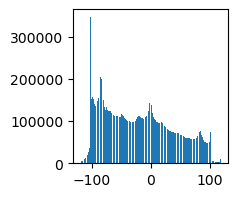

min: 0
max: 40
p0_pos_z


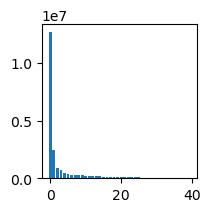

min: -46
max: 46
p0_vel_x


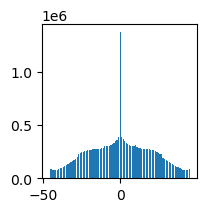

min: -46
max: 46
p0_vel_y


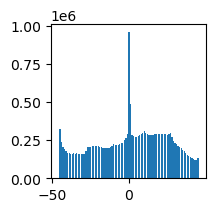

min: -45
max: 45
p0_vel_z


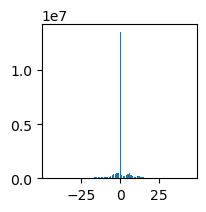

min: 0
max: 100
p0_boost


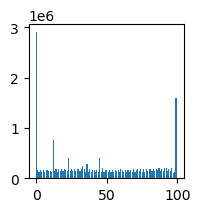

min: -81
max: 81
p1_pos_x


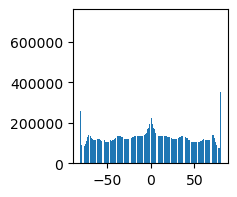

min: -119
max: 119
p1_pos_y


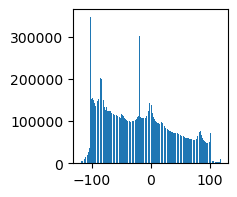

min: 0
max: 40
p1_pos_z


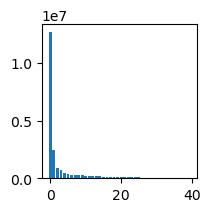

min: -46
max: 46
p1_vel_x


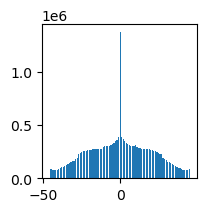

min: -46
max: 46
p1_vel_y


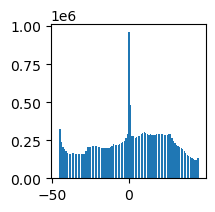

min: -45
max: 45
p1_vel_z


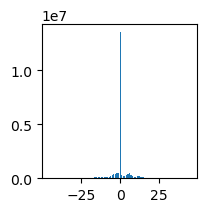

min: 0
max: 100
p1_boost


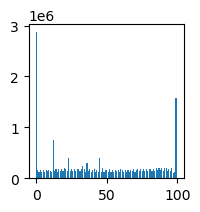

min: -82
max: 81
p2_pos_x


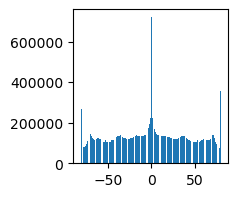

min: -119
max: 119
p2_pos_y


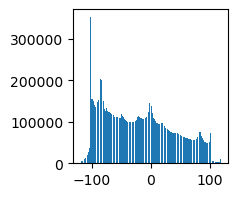

min: 0
max: 40
p2_pos_z


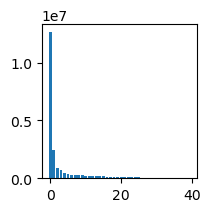

min: -46
max: 46
p2_vel_x


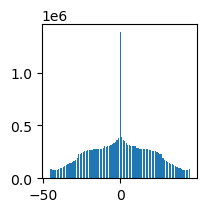

min: -46
max: 46
p2_vel_y


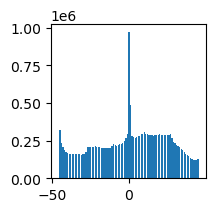

min: -45
max: 45
p2_vel_z


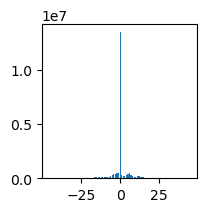

min: 0
max: 100
p2_boost


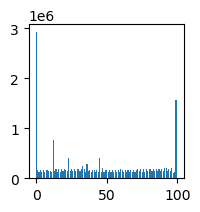

min: -81
max: 81
p3_pos_x


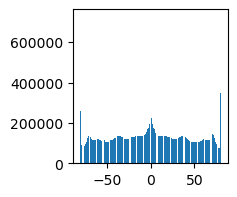

min: -119
max: 119
p3_pos_y


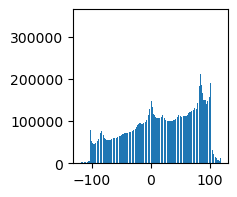

min: 0
max: 40
p3_pos_z


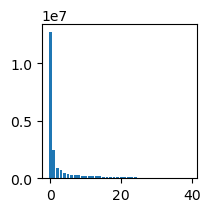

min: -46
max: 46
p3_vel_x


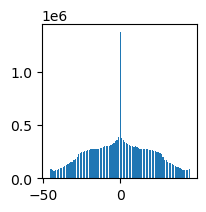

min: -46
max: 46
p3_vel_y


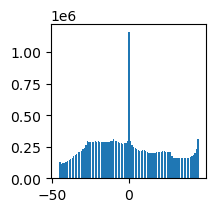

min: -45
max: 45
p3_vel_z


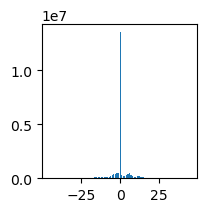

min: 0
max: 100
p3_boost


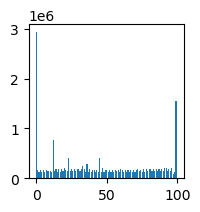

min: -82
max: 82
p4_pos_x


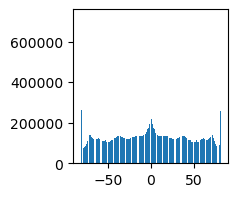

min: -119
max: 119
p4_pos_y


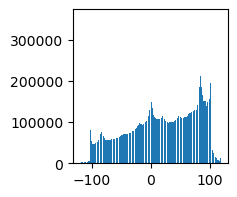

min: 0
max: 40
p4_pos_z


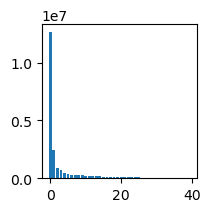

min: -46
max: 46
p4_vel_x


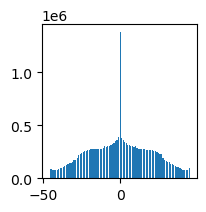

min: -46
max: 46
p4_vel_y


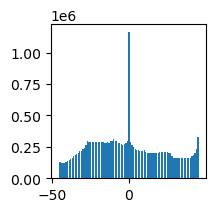

min: -45
max: 45
p4_vel_z


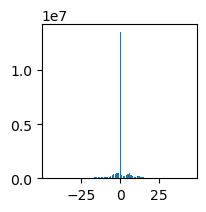

min: 0
max: 100
p4_boost


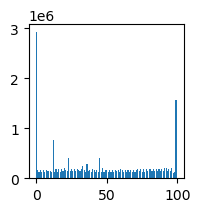

min: -82
max: 81
p5_pos_x


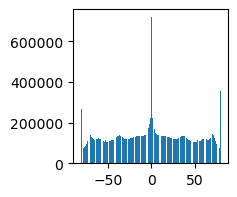

min: -119
max: 119
p5_pos_y


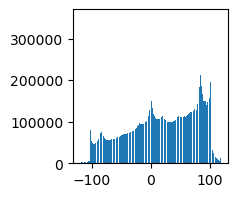

min: 0
max: 40
p5_pos_z


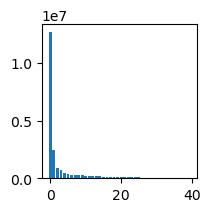

min: -46
max: 46
p5_vel_x


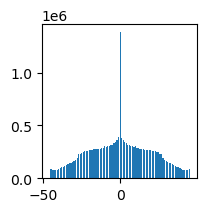

min: -46
max: 46
p5_vel_y


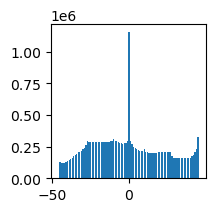

min: -45
max: 45
p5_vel_z


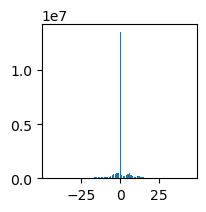

min: 0
max: 100
p5_boost


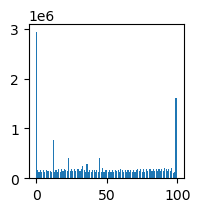

min: -9
max: 0
boost0_timer


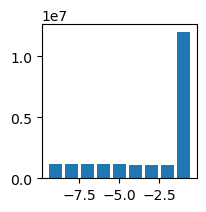

min: -9
max: 0
boost1_timer


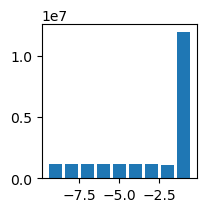

min: -9
max: 0
boost2_timer


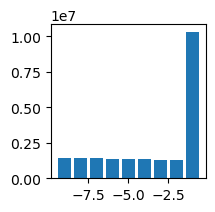

min: -9
max: 0
boost3_timer


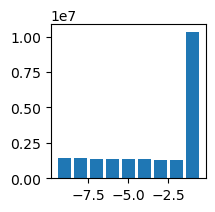

min: -9
max: 0
boost4_timer


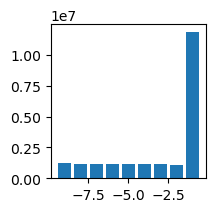

min: -9
max: 0
boost5_timer


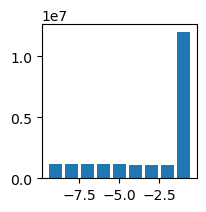

min: -1
max: 5
player_scoring_next


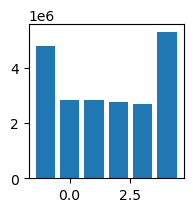

min: 0
max: 1
team_A_scored


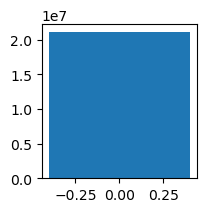

min: 0
max: 1
team_B_scored


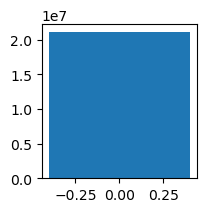

min: 0
max: 1
team_A_scoring_within_10sec


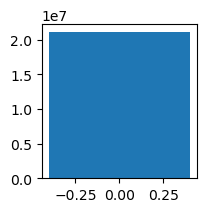

min: 0
max: 1
team_B_scoring_within_10sec


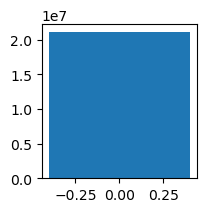

In [60]:
for c in df.columns:
    if c!='event_id':
        histogram(df[c], True)

In [ ]:
df.p0_pos_x.isna().value_counts()